In [1]:
import os
import seaborn as sns
import pandas as pd
import geopandas as gpd
import re, io, numpy as np
from cStringIO import StringIO 
from pandas.api.types import CategoricalDtype

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)  #DEBUG, INFO, WARNING, ERROR, CRITICAL

In [2]:
%pylab inline
# Get current size
fig_size = plt.rcParams["figure.figsize"]
print "Current size:", fig_size
# Set figure width to 12 and height to 9
fig_size[0] = 10
fig_size[1] = 6.5
plt.rcParams["figure.figsize"] = fig_size
print "Current size:", fig_size
plt.rcParams['figure.figsize']
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib
Current size: [6.0, 4.0]
Current size: [10, 6.5]


In [3]:
drop=os.getenv('DROPBOX_LOC')
box=os.getenv('BOX_LOC')

In [4]:
import matplotlib.ticker as ticker
fmt = lambda x,pos: '{:,.0f}'.format(x)
cbar_kws={'format': ticker.FuncFormatter(fmt)}
fmt_float = lambda x,pos: '{:,.3f}'.format(x)
cbar_kws_float={'format': ticker.FuncFormatter(fmt_float)}
import matplotlib.patches as patches

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as colors
import matplotlib.patheffects as PathEffects

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Generate a multitude of headship rates from different time periods / vintages, and geographies

### Prepare geographic mappings

In [8]:
atlantacounties=['Henry','Cobb','Rockdale','DeKalb','Gwinnett','Douglas','Cherokee','Fulton','Fayette','Clayton']

In [9]:
uscnty=gpd.read_file(os.path.join(drop,'Documents/Data/GIS/Census/tiger/cb_2015_us_county_500k.shp'))
uscnty.loc[(uscnty.STATEFP=='13')&(uscnty.NAME.isin(atlantacounties))].set_index('GEOID').NAME.to_dict()

{u'13057': u'Cherokee',
 u'13063': u'Clayton',
 u'13067': u'Cobb',
 u'13089': u'DeKalb',
 u'13097': u'Douglas',
 u'13113': u'Fayette',
 u'13121': u'Fulton',
 u'13135': u'Gwinnett',
 u'13151': u'Henry',
 u'13247': u'Rockdale'}

In [10]:
bayareafips_full ={'06001':'Alameda', '06013':'Contra Costa', '06041':'Marin', '06055':'Napa', '06075':'San Francisco', '06081':'San Mateo', '06085':'Santa Clara', '06097':'Sonoma', '06095':'Solano'}
cntystring='({})'.format('|'.join(bayareafips_full.values()))

remiregions={'Alameda': 'East Bay',
 'Contra Costa': 'East Bay',
 'Marin': 'West Bay',
 'Napa': 'North Bay',
 'San Francisco': 'West Bay',
 'San Mateo': 'West Bay',
 'Santa Clara': 'South Bay',
 'Solano': 'North Bay',
 'Sonoma': 'North Bay'}

atlanta_regional={u'13057': u'Cherokee',
 u'13063': u'Clayton',
 u'13067': u'Cobb',
 u'13089': u'DeKalb',
 u'13097': u'Douglas',
 u'13113': u'Fayette',
 u'13121': u'Fulton',
 u'13135': u'Gwinnett',
 u'13151': u'Henry',
 u'13247': u'Rockdale'}


atlanta_regional={u'13057': u'Atlanta Regional',
 u'13063': u'Atlanta Regional',
 u'13067': u'Atlanta Regional',
 u'13089': u'Atlanta Regional',
 u'13097': u'Atlanta Regional',
 u'13113': u'Atlanta Regional',
 u'13121': u'Atlanta Regional',
 u'13135': u'Atlanta Regional',
 u'13151': u'Atlanta Regional',
 u'13247': u'Atlanta Regional'}

## for halo counties, rely on the regionalization in 
## http://www.cdss.ca.gov/research/res/pdf/multireports/RegionsofCalifornia.pdf


halofips = {'06077':'San Joaquin','06099':'Stanislaus','06067':'Sacramento','06047':'Merced',
           '06113':'Yolo','06115':'Yuba','06101':'Sutter','06017':'El Dorado','06061':'Placer',
            '06087':'Santa Cruz','06069':'San Benito','06053':'Monterey',
            '06033':'Lake','06045':'Mendocino','outside':'outside'}

halotype={'06077':'Halo Southern Farm','06047':'Halo Southern Farm','06033':'North and Mountains','06045':'Mendocino',
          '06045':'Halo North and Mountains',
          '06099':'Halo Southern Farm','06067':'Halo Central Valley',
           '06113':'Halo Central Valley','06115':'Halo Central Valley','06101':'Halo Central Valley',
          '06017':'Halo Central Valley','06061':'Halo Central Valley',
            '06087':'Halo Bay Area','06069':'Halo Southern Farm','06053':'Halo Southern Farm','outside':'outside'}

## mapping for REMI area grouping
bayarearegions={'06001':'East Bay',
 '06013':'East Bay',
 '06085':'South Bay',
 '06055':'North Bay',
 '06081':'West Bay',
 '06075':'West Bay',
 '06097':'North Bay',
 '06041':'West Bay',
 '06095':'North Bay',
               }
regiontype=bayarearegions.copy()
regiontype.update(halotype)

bothfips = bayareafips_full.copy()
bothfips.update(halofips)

north_bay =  {'06055':'North Bay',
 '06097':'North Bay',
 '06095':'North Bay'}

In [11]:
regiontype_gen={'06001': 'Bay Area',
 '06013': 'Bay Area',
 '06017': 'Rest of CA',
 '06033':'Rest of CA',
 '06045':'Rest of CA',
 '06041': 'Bay Area',
 '06047': 'Rest of CA',
 '06053': 'Rest of CA',
 '06055': 'Bay Area',
 '06061': 'Rest of CA',
 '06067': 'Rest of CA',
 '06069': 'Rest of CA',
 '06075': 'Bay Area',
 '06077': 'Rest of CA',
                '06073':'SANDAG',
 '06081': 'Bay Area',
 '06085': 'Bay Area',
 '06087': 'Rest of CA',
 '06095': 'Bay Area',
 '06097': 'Bay Area',
 '06099': 'Rest of CA',
 '06101': 'Rest of CA',
 '06113': 'Rest of CA',
 '06115': 'Rest of CA',
                 '06025': 'SCAG',  # imperial
 '06037': 'SCAG',   # LA
 '06071': 'SCAG',  # san bernadino
 '06059': 'SCAG',  # orange
 '06065': 'SCAG',  # riverside
 '06011': 'SCAG', # ventura
 'outside': 'outside',
               u'13057': u'Atlanta Regional',
 u'13063': u'Atlanta Regional',
 u'13067': u'Atlanta Regional',
 u'13089': u'Atlanta Regional',
 u'13097': u'Atlanta Regional',
 u'13113': u'Atlanta Regional',
 u'13121': u'Atlanta Regional',
 u'13135': u'Atlanta Regional',
 u'13151': u'Atlanta Regional',
 u'13247': u'Atlanta Regional'}

In [12]:
regiontype_gen_halodetail={'06001': 'Bay Area',
 '06013': 'Bay Area',
 '06017': 'Halo Central Valley',           
 '06033':'Halo North and Mountains',
 '06045':'Halo North and Mountains',
 '06041': 'Bay Area',
 '06047': 'Halo Southern Farm',
 '06053': 'Halo Southern Farm',
 '06055': 'Bay Area',
 '06061': 'Halo Central Valley',
 '06067': 'Halo Central Valley',
 '06069': 'Halo Southern Farm',
 '06075': 'Bay Area',
 '06077': 'Halo Southern Farm',
 '06081': 'Bay Area',
 '06085': 'Bay Area',
 '06087': 'Halo Bay Area',
 '06095': 'Bay Area',
 '06097': 'Bay Area',
 '06099': 'Halo Southern Farm',
 '06101': 'Halo Central Valley',
 '06113': 'Halo Central Valley',
 '06115': 'Halo Central Valley',
 '06025': 'SCAG',  # imperial
 '06037': 'SCAG',   # LA
 '06071': 'SCAG',  # san bernadino
 '06059': 'SCAG',  # orange
 '06065': 'SCAG',  # riverside
 '06011': 'SCAG', # ventura
                           
                           
 'outside': 'outside'}

In [13]:
## puma to county relationship file

pumarel=pd.read_csv(os.path.join(drop,'Documents/Data/_Census/geo/2010_Census_Tract_to_2010_PUMA.txt'),dtype=str)
pumarel['STPUMA']=pumarel.STATEFP+pumarel.PUMA5CE
pumarel['STCOUNTY']=pumarel.STATEFP+pumarel.COUNTYFP
pumarel=pumarel.groupby(['STPUMA','STCOUNTY']).size().groupby(level=0,group_keys=False).nlargest(1).reset_index(1).STCOUNTY
pumarel.head()

STPUMA
0100100    01077
0100200    01083
0100301    01089
0100302    01089
0100400    01049
Name: STCOUNTY, dtype: object

### define a few convenience functions

In [14]:
pct=lambda x: x/x.sum()

def incbreaker(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("${fr:,.0f}-${to:,.0f}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='${dt:,.0f}+'.format(dt=breaks[-2])
    return labels


def agebreaker(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("age{fr:02.0f}{to:02.0f}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='age{dt:,.0f}p'.format(dt=breaks[-2])
    return labels
def agebreaker2(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("Ages {fr:.0f}-{to:.0f}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='Ages {dt:,.0f}+'.format(dt=breaks[-2])
    return labels

diffbreaks_custom =[0,18,25,45,65,np.inf]
diffbreaks_5 =range(0,86,5)+[np.inf]

In [15]:
def map_value_labels(codes_pasted,var):
    """
    Reads pasted id:value correspondence and prepares a 
    id:value dictionary to be used for mapping
    """
    
    ## substitute dots and leading space
    codes_pasted = re.sub(r' \.','\t', codes_pasted)
    
    ## read code string as if it were a file object, store in dataframe
    df_codes = pd.read_csv(StringIO(codes_pasted), 
                           encoding='utf8', sep="\t",
                           header=None if os.name=='posix' else None,
                           names=['id','value'],
                           dtype={'id': object, 'value': object})
    
    df_codes['value']=df_codes['value'].str.strip()
    df_codes.index=df_codes.id.astype(np.int64)
    df_codes=df_codes['value'].to_dict()
    
    return df_codes

In [16]:
def race_eth(df):
    if df.name>1:
        return 'Hispanic'
    else:
        return df+'-NonHispanic'

### Paste codes from PUMS data dictionary, and modify as needed

In [17]:
codesrace ="""
1 .white
2 .black
3 .other
4 .other
5 .other
6 .asian
7 .other
8 .other
9 .other
"""
codesworkers="""
0 .No workers
1 .1 worker
2 .2 workers
3 .3 or more workers in family
"""
## REMI doesn't have much race detail, so we don't either.
codesraceREMI ="""
1 .White
2 .Black
3 .Other
4 .Other
5 .Other
6 .Other
7 .Other
8 .Other
9 .Other
"""

In [18]:
## get value labels
race_value_map = map_value_labels(codesrace,'RAC1P')
workers_value_map = map_value_labels(codesworkers,'WIF')
remirace_value_map = map_value_labels(codesraceREMI,'RAC1P')
remirace_value_map

{1: u'White',
 2: u'Black',
 3: u'Other',
 4: u'Other',
 5: u'Other',
 6: u'Other',
 7: u'Other',
 8: u'Other',
 9: u'Other'}

## Load PUMS sample data

In [19]:
## set ACS vars

VINTAGE=2018
SAMPLE=5

acsvintagestr='{:}_{:}'.format(VINTAGE-4,VINTAGE) if SAMPLE==5 else '{:}'.format(VINTAGE)
acsvintagestr

persons_file='/Users/aolsen/Dropbox/Documents/Data/_Census/ACS/PUMS/{acsvintage}/psam_p06.csv'.format(acsvintage=acsvintagestr)
persons_file

'/Users/aolsen/Dropbox/Documents/Data/_Census/ACS/PUMS/2014_2018/psam_p06.csv'

In [20]:
## create map of local ACS files to load

acsmap={'ACS2018_5':{'VINTAGE':2018,'SAMPLE':5},
'ACS2016_5':{'VINTAGE':2016,'SAMPLE':5},
'ACS2018_1':{'VINTAGE':2018,'SAMPLE':1}}

In [65]:
allpersons={}
for k,v in acsmap.iteritems():
    print k,v
    acsvintagestr='{:}_{:}'.format(v['VINTAGE']-4,v['VINTAGE']) if v['SAMPLE']==5 else '{:}'.format(v['VINTAGE'])
    
    ## format file string
    persons_file='/Users/aolsen/Dropbox/Documents/Data/_Census/ACS/PUMS/{acsvintage}/psam_p06.csv'.format(acsvintage=acsvintagestr)
    print persons_file
    persons_temp=pd.read_csv(persons_file,usecols=['PWGTP','AGEP','RAC1P','HISP','ST','PUMA','SEX','RELP'])
    persons_temp['YEAR']=v['VINTAGE']
    
    allpersons[(k)]=persons_temp
persons=pd.concat(allpersons,names=['VINTAGE','OID'])

ACS2016_5 {'SAMPLE': 5, 'VINTAGE': 2016}
/Users/aolsen/Dropbox/Documents/Data/_Census/ACS/PUMS/2012_2016/psam_p06.csv
ACS2018_5 {'SAMPLE': 5, 'VINTAGE': 2018}
/Users/aolsen/Dropbox/Documents/Data/_Census/ACS/PUMS/2014_2018/psam_p06.csv
ACS2018_1 {'SAMPLE': 1, 'VINTAGE': 2018}
/Users/aolsen/Dropbox/Documents/Data/_Census/ACS/PUMS/2018/psam_p06.csv


In [76]:
persons.groupby(['VINTAGE']).PWGTP.sum()

AttributeError: 'DataFrameGroupBy' object has no attribute 'PWGTP'

### Load data and do key assignments

In [68]:
%%time

persons['STPUMA']=persons.ST.apply(lambda x: '{:0>2}'.format(x))+persons.PUMA.apply(lambda x: '{:0>5}'.format(x))
persons['STPUMA']=persons['STPUMA'].astype('category')
persons['county']=persons.STPUMA.replace(pumarel).fillna('').map(regiontype_gen).fillna('Rest of CA').astype('category')

## assign key person variables
persons['age_grp_5']=pd.cut(persons.AGEP, right=False,bins=diffbreaks_5,labels=agebreaker2(diffbreaks_5))

persons['sex']=persons.SEX.map({1:'male',2:'female'})

## add race / ethnicity 
persons['race_remi']=persons.RAC1P.map(remirace_value_map)
persons['rac_ethn']=persons.groupby(['HISP'])['race_remi'].transform(race_eth)

persons=persons.drop(labels=['SEX'],axis=1)

CPU times: user 2min 15s, sys: 11.9 s, total: 2min 26s
Wall time: 2min 57s


In [77]:
persons.columns=persons.columns.str.lower()

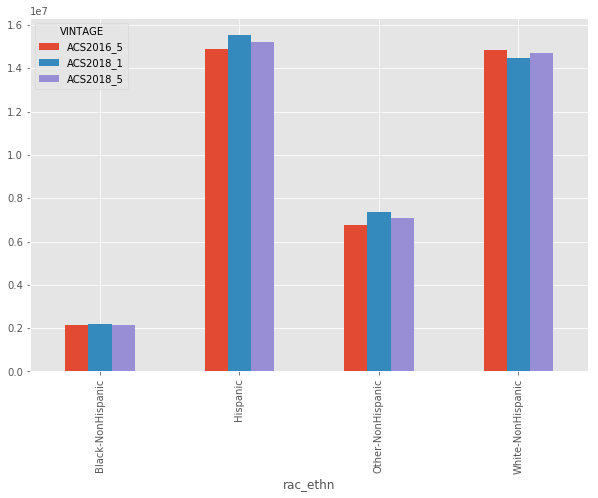

In [78]:
persons.groupby(['VINTAGE','rac_ethn']).pwgtp.sum().unstack(0).plot(kind='bar')

### Create headship rates
We need householders relative to the household population, for relevant subgroups. `RELP` is our friend.

In [79]:
## set groups of interest for the headship rates - we treat the bay area as "county"

hhgrp=['VINTAGE','county','rac_ethn','age_grp_5']

In [80]:
## numerator - householders

#numerator=persons.loc[(~persons.relp.isin([16,17]))&(persons.sporder==1)].groupby(hhgrp).pwgtp.sum()
numerator=persons.loc[persons.relp.isin([0])].groupby(hhgrp).pwgtp.sum()
numerator.head()

VINTAGE    county    rac_ethn           age_grp_5 
ACS2016_5  Bay Area  Black-NonHispanic  Ages 15-19      483
                                        Ages 20-24     4661
                                        Ages 25-29    10716
                                        Ages 30-34    13585
                                        Ages 35-39    14370
Name: pwgtp, dtype: int64

In [81]:
## denominator - at risk population (household population, excluding group quarter households)

denominator=persons.loc[(~persons.relp.isin([16,17]))].groupby(hhgrp).pwgtp.sum()
denominator.head()

VINTAGE    county    rac_ethn           age_grp_5 
ACS2016_5  Bay Area  Black-NonHispanic  Ages 0-4      23884
                                        Ages 5-9      25222
                                        Ages 10-14    26138
                                        Ages 15-19    27513
                                        Ages 20-24    30507
Name: pwgtp, dtype: int64

In [82]:
headship=numerator.div(denominator,axis=0)

In [83]:
headship.unstack('VINTAGE').loc['Bay Area','White-NonHispanic',agebreaker2(diffbreaks_5)].dropna().reset_index([0,1],drop=True)

VINTAGE,ACS2016_5,ACS2018_1,ACS2018_5
age_grp_5,,,
Ages 15-19,0.014043,0.005330,0.009987
Ages 20-24,0.169837,0.138808,0.153220
Ages 25-29,0.360216,0.337582,0.342035
Ages 30-34,0.488212,0.473256,0.474900
Ages 35-39,0.516088,0.496612,0.508238
Ages 40-44,0.541499,0.535542,0.532306
Ages 45-49,0.559933,0.556596,0.559316
Ages 50-54,0.573301,0.564117,0.569824
Ages 55-59,0.583445,0.570618,0.576831


### Plot Bay Area headship rates, by age, race / ethnicity

(array([0.5, 1.5, 2.5]), <a list of 3 Text xticklabel objects>)

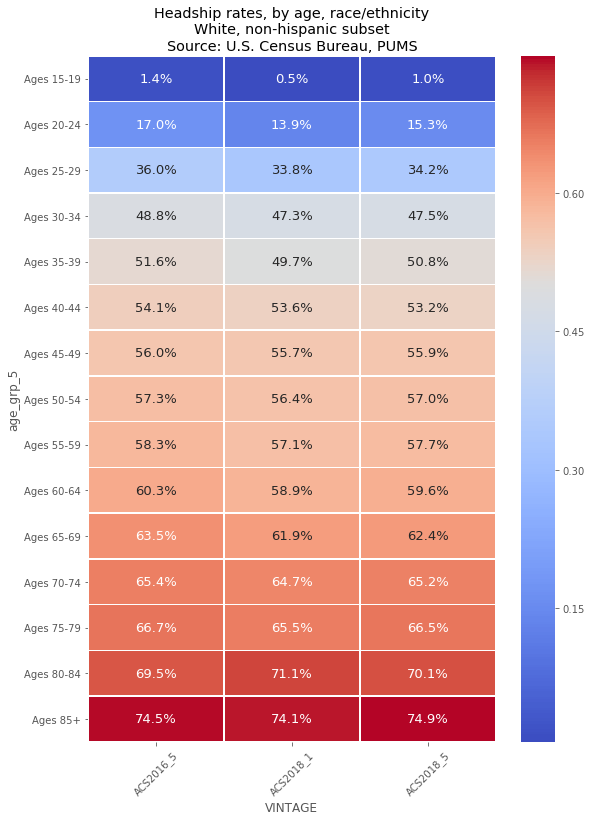

In [85]:
fmt_abs = lambda x,pos: '{:,.2f}'.format(x)

fig, ax = plt.subplots()
fig.set_figwidth(8.5)
fig.set_figheight(11)        
ax=sns.heatmap(headship.unstack('VINTAGE').loc['Bay Area','White-NonHispanic',agebreaker2(diffbreaks_5)].dropna().reset_index([0,1],drop=True),
             annot=True, fmt='.1%',annot_kws={"size": 13.1,'rotation':0},linewidths=.5,
              cbar_kws={'format': FuncFormatter(fmt_abs)},
               cmap=cm.coolwarm,norm=MidpointNormalize(midpoint=.5));
title('Headship rates, by age, race/ethnicity\nWhite, non-hispanic subset\nSource: U.S. Census Bureau, PUMS')
plt.tight_layout()
plt.xticks(rotation=45)

In [203]:
## write rates to disk

headship.reset_index(name='value').fillna(0).to_csv(os.path.join(drop,'Data/PBA2050/headship_stateregions_2014_2018.csv'))